In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Paths
PREDICTIONS_DIR = Path("../predictions")

# Assets
ASSETS = ["AAPL", "IBEX35", "MSFT", "NASDAQ", "S&P500"]

# Matplotlib style
plt.style.use("seaborn-v0_8-darkgrid")

In [3]:
# Extra metrics
def mean_bias_error(y_true, y_pred):
    return np.mean(y_true - y_pred)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [4]:
def evaluate_all_metrics(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "MAPE (%)": mean_absolute_percentage_error(y_true, y_pred),
        "MBE": mean_bias_error(y_true, y_pred)
    }


=== AAPL ===


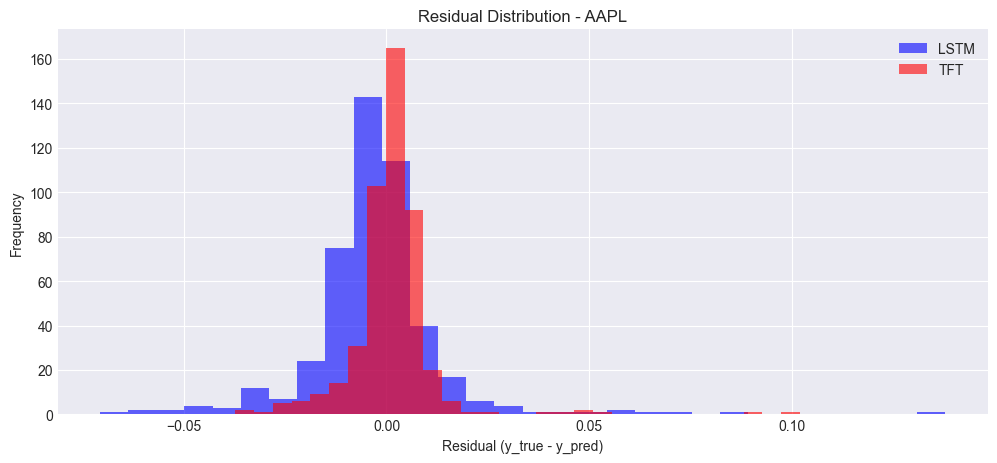

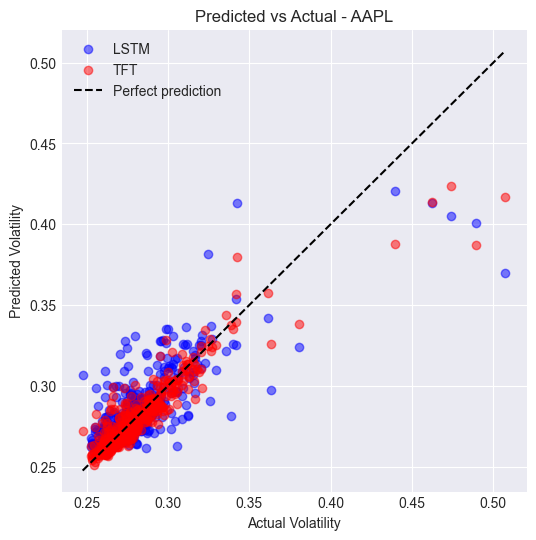


=== IBEX35 ===


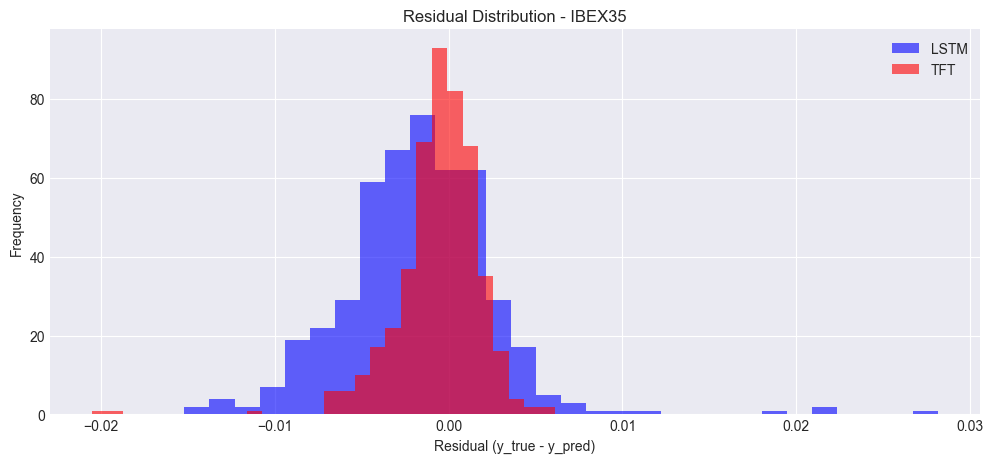

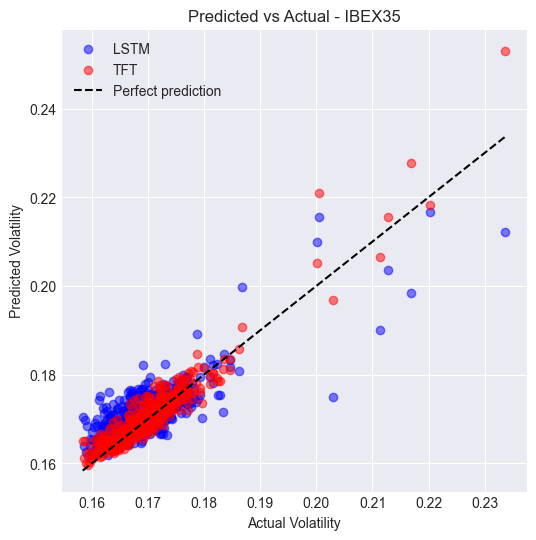


=== MSFT ===


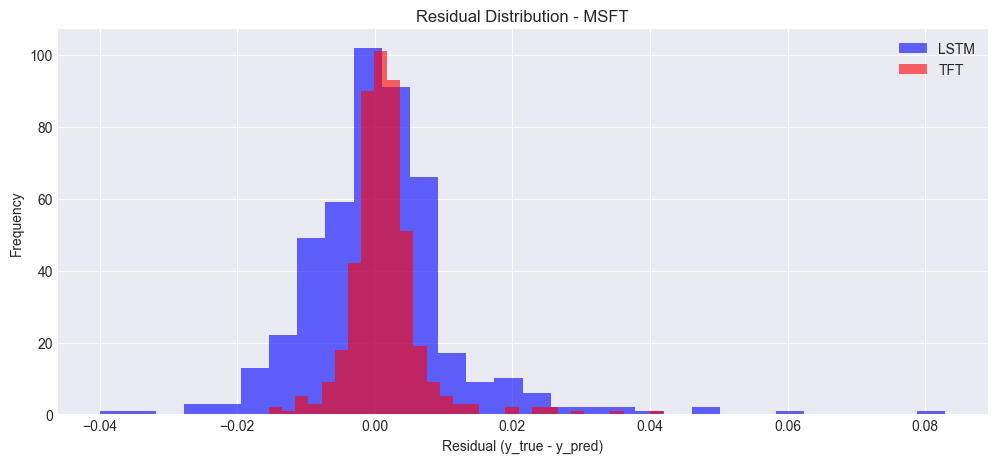

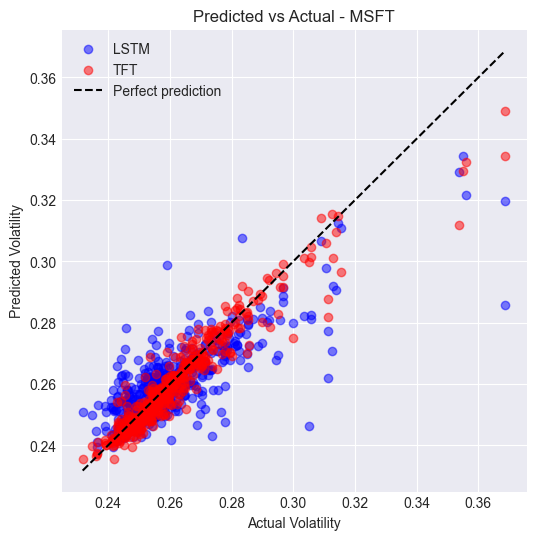


=== NASDAQ ===


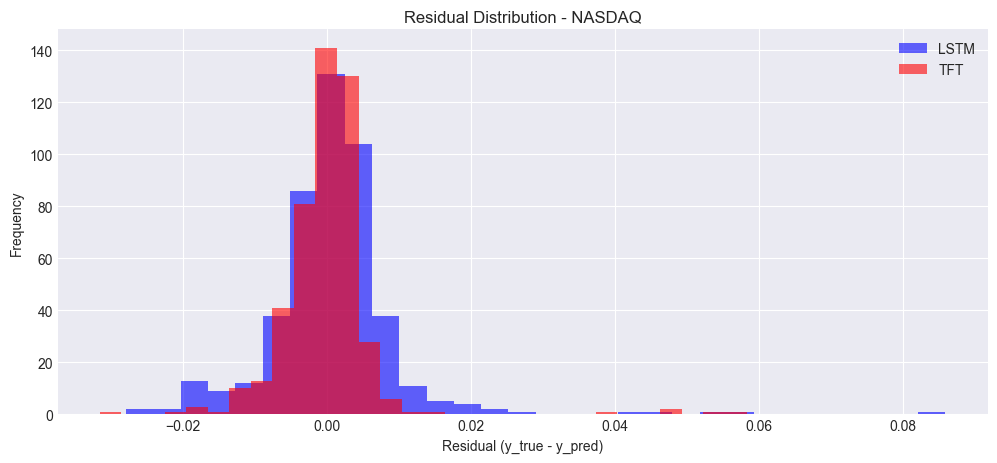

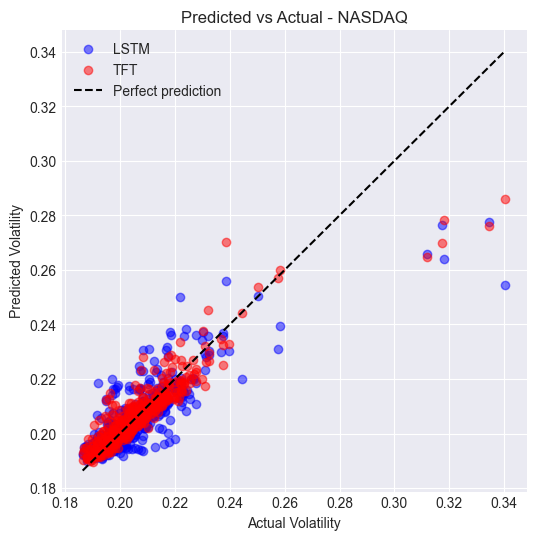


=== S&P500 ===


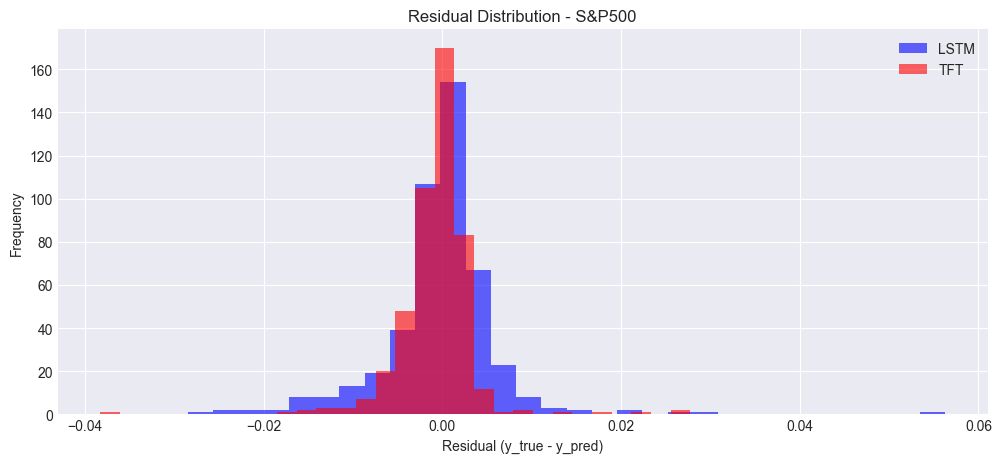

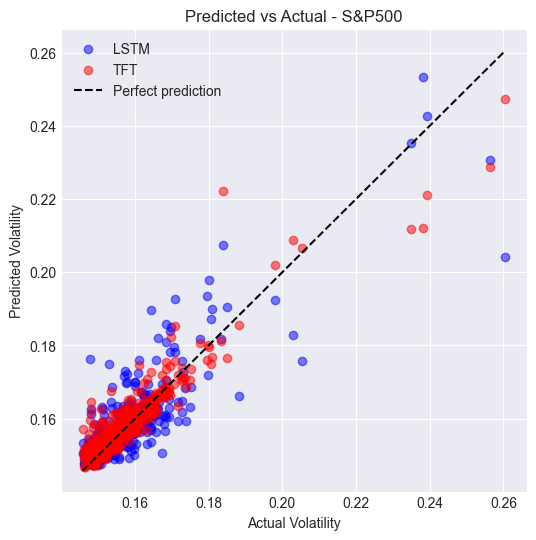

In [5]:
# Compute residuals and metrics
results = []

for asset in ASSETS:
    print(f"\n=== {asset} ===")
    
    # Load predictions
    lstm_df = pd.read_csv(PREDICTIONS_DIR / f"predictions_lstm_{asset}.csv", parse_dates=["date"])
    tft_df = pd.read_csv(PREDICTIONS_DIR / f"predictions_tft_{asset}.csv", parse_dates=["date"])
    
    # Compute metrics
    lstm_metrics = evaluate_all_metrics(lstm_df["y_true"], lstm_df["y_pred"])
    tft_metrics = evaluate_all_metrics(tft_df["y_true"], tft_df["y_pred"])
    
    # Store results in a single row
    row = {"asset": asset}
    for metric, value in lstm_metrics.items():
        row[f"{metric}_LSTM"] = value
    for metric, value in tft_metrics.items():
        row[f"{metric}_TFT"] = value
    results.append(row)
    
    # Residual histograms
    lstm_residuals = lstm_df["y_true"] - lstm_df["y_pred"]
    tft_residuals = tft_df["y_true"] - tft_df["y_pred"]
    
    plt.figure(figsize=(12, 5))
    plt.hist(lstm_residuals, bins=30, alpha=0.6, label="LSTM", color="blue")
    plt.hist(tft_residuals, bins=30, alpha=0.6, label="TFT", color="red")
    plt.title(f"Residual Distribution - {asset}")
    plt.xlabel("Residual (y_true - y_pred)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    # Scatter plot Predicted vs Actual
    plt.figure(figsize=(6, 6))
    plt.scatter(lstm_df["y_true"], lstm_df["y_pred"], alpha=0.5, label="LSTM", color="blue")
    plt.scatter(tft_df["y_true"], tft_df["y_pred"], alpha=0.5, label="TFT", color="red")
    min_val = min(lstm_df["y_true"].min(), tft_df["y_true"].min())
    max_val = max(lstm_df["y_true"].max(), tft_df["y_true"].max())
    plt.plot([min_val, max_val], [min_val, max_val], color="black", linestyle="--", label="Perfect prediction")
    plt.title(f"Predicted vs Actual - {asset}")
    plt.xlabel("Actual Volatility")
    plt.ylabel("Predicted Volatility")
    plt.legend()
    plt.show()

In [6]:
# Create final summary DataFrame
metrics_df = pd.DataFrame(results)

# Save to CSV
metrics_df.to_csv(PREDICTIONS_DIR / "metrics_all_summary.csv", index=False)

In [7]:
# Highlight best per metric
def highlight_best(df, metric, higher_is_better):
    if higher_is_better:
        best_val = df[[f"{metric}_LSTM", f"{metric}_TFT"]].max(axis=1)
    else:
        best_val = df[[f"{metric}_LSTM", f"{metric}_TFT"]].min(axis=1)
    
    style = pd.DataFrame("", index=df.index, columns=df.columns)
    for model in ["LSTM", "TFT"]:
        col = f"{metric}_{model}"
        style.loc[df[col] == best_val, col] = "background-color: lightgreen"
    return style

In [8]:
style_df = metrics_df.style \
    .apply(lambda x: highlight_best(metrics_df, "RMSE", higher_is_better=False), axis=None) \
    .apply(lambda x: highlight_best(metrics_df, "MAE", higher_is_better=False), axis=None) \
    .apply(lambda x: highlight_best(metrics_df, "R2", higher_is_better=True), axis=None) \
    .apply(lambda x: highlight_best(metrics_df, "MAPE (%)", higher_is_better=False), axis=None) \
    .apply(lambda x: highlight_best(metrics_df, "MBE", higher_is_better=False), axis=None) \
    .format(precision=4)

style_df

,asset,RMSE_LSTM,MAE_LSTM,R2_LSTM,MAPE (%)_LSTM,MBE_LSTM,RMSE_TFT,MAE_TFT,R2_TFT,MAPE (%)_TFT,MBE_TFT
0,AAPL,0.0168,0.0103,0.6343,3.5248,-0.0030,0.0109,0.0061,0.8467,2.0616,0.0014
1,IBEX35,0.0048,0.0035,0.6150,2.0467,-0.0017,0.0026,0.0017,0.8892,1.0011,-0.0006
2,MSFT,0.0111,0.0074,0.6317,2.7369,0.0007,0.0056,0.0035,0.9058,1.2947,0.0014
3,NASDAQ,0.0093,0.0056,0.6909,2.5759,0.0007,0.0070,0.0038,0.8262,1.7574,-0.0000
4,S&P500,0.0065,0.0040,0.7207,2.4072,-0.0002,0.0044,0.0026,0.8706,1.5979,-0.0007
